# Evaluate different policies in the simulated environment - Sequential

## Description of the simulated environment
1. Goal: Detect terminal event with the smallest cost
1. Label: {0, 1}, 0 indicates normal, 5 1's indicates terminal event
1. Reponse: a time series composed of 0 and 1
    1. Generate under a markov chain
        1. $p(L_{t+1} = 0 |L_{t} = 0) = 0.98$
        1. $p(L_{t+1} = 0 |L_{t} = 1) = 0.1$
        1. $p(L_{t+1} = 1 |L_{t} = 0) = 1.0$
        1. $p(L_{t+1} = 1 |L_{t} = 1) = 0.0$
    1. The series terminate with 5 1's
1. Time series measurements generated according to the label
    1. 5 informative features
        1. $1 \pm \epsilon$ if $L=1$
        1. $-1 \pm \epsilon$ if $L=0$
    1. 5 noisy features
        1. ${\pm1} \pm \epsilon$
    1. Randomly introduced missingness to create incompleted dataset
        1. missing value is encoder as $0$
        1. Missingness rate used: 0.5
1. Size of Training + Val set: 5000

    
## Description of classifier for event forcasting 
1. A softmax that takes in
    1. a state consisiting of measurements of the 5 most recent time steps and,
    1. a feature importance vector: [1, 2, 3, 4, 5, 0, 0, 0, 0, 0]
    1. Information decay rate: 0.5
1. A Softmax output a probability of event occur within 5 time steps

## Description of the RL problem
1. State
    1. a state consisting of measurements of the 5 most recent time steps
1. Action
    1. all possible measurement that can be done for the next time point plus time-pass operation
1. Reward
    1. Change in probability weighted by next state's label
    1. Measurement cost


## Evaluation in an online setting
1. Agent observ state $s_t$
    1. $s_0$: A state without any measurement (fill by zeros)
1. Agent decide action $a_t$
1. Environment generate next state $s_{t+1}$
1. Calculated reward and expected returns


In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import argparse
import pickle

import numpy as np
import tensorflow as tf

from arch.Sequencial_Dueling_DQN import SequencialDuelingDQN
from run_dqn_dummy import reward_function
from run_dqn_dummy import to_one_hot
from sim_observation_dummy_disease import ExperienceGeneratorSequential
from simulated_patient_database import DummyDisease, DummyClassifier, SimulatedPatientDatabaseDiscrete

In [3]:
def _get_random_action(history_action, done, num_to_choose, valid_action_inds):
    n_s, n_a = history_action.shape

    def per_s_helper(history_action_i):
        if np.sum(history_action_i) == min(num_to_choose, len(valid_action_inds)):
            return n_a

        usable_actions = [j for j in valid_action_inds if not history_action_i[j]]
        return np.random.choice(usable_actions)

    action_inds = np.array(list(map(per_s_helper, history_action)))

    return to_one_hot(action_inds, n_a + 1, done)


def parse_args():
    parser = argparse.ArgumentParser(description='Evaluate policy')

    parser.add_argument('--seed', type=int, default=0)
    parser.add_argument('--gamma', type=float, default=0.95)
    parser.add_argument('--num_patients', type=int, default=500)
    parser.add_argument('--reward_params', type=float, default=[200, 5, 1])
    parser.add_argument('--early_detect_time', type=int, default=5)
    parser.add_argument('--dataset_setting_path', type=str,
                        default='../data/simulated_disease/1126_hyperparameters.pkl')
    parser.add_argument('--dqn_model_path', type=str,
                        default='../models/dqn-dummy1205-o50-a11-g0.999-1-m10000-nn1-3-16-lr0.001-0.0001-0.5-s128-15000-i1000-500-10-r(200, 5, 1)-d0.5-r0/')

    args = parser.parse_args([])
    return args

In [4]:
args = parse_args()

np.random.seed(args.seed)
tf.set_random_seed(args.seed)

reward_func = lambda **kwargs: reward_function(reward_params=args.reward_params, **kwargs)

dataset_setting = pickle.load(open(args.dataset_setting_path, 'rb'))

classifier = DummyClassifier(num_useful_features=dataset_setting.num_useful_features,
                             num_noisy_features=dataset_setting.num_noisy_features,
                             obs_t_dim=dataset_setting.max_num_terminal_states,
                             information_decay_rate=dataset_setting.information_decay_rate)

disease = DummyDisease(feature_noise=dataset_setting.feature_noise,
                       max_num_terminal_states=dataset_setting.max_num_terminal_states,
                       num_useful_features=dataset_setting.num_useful_features,
                       num_noisy_features=dataset_setting.num_noisy_features,
                       num_datapoints_per_period=dataset_setting.num_datapoints_per_period,
                       period_length=dataset_setting.period_length,
                       min_periods=dataset_setting.min_periods, max_periods=dataset_setting.max_periods,
                       keep_rate=1.0)

patient_database = SimulatedPatientDatabaseDiscrete(obs_type=disease, num_patients=args.num_patients)

print('Rate of death: {}/{}'.format(np.sum(patient_database.all_labels), args.num_patients))

exp_generator = ExperienceGeneratorSequential(patient_database=patient_database, classifier=classifier,
                                              early_detect_time=args.early_detect_time, num_orders=1)

Rate of death: 49/500


In [5]:
def evaluate_random_policy(num_to_choose, informative=True):
    print(f'Num to choose: {num_to_choose}, informative: {informative}')
    get_random_informative_action = lambda delay_cur_state, history_action, done: \
        _get_random_action(history_action=history_action,
                           done=done,
                           num_to_choose=num_to_choose,
                           valid_action_inds=np.arange(disease.num_useful_features) \
                               if informative else np.arange(disease.num_features))

    results = exp_generator.evaluate_batch(get_action=get_random_informative_action, reward_func=reward_func)

    results['gamma'] = args.gamma
    exp_generator.summarize(dic=results)
    return results 

def evaluate_dqn_policy(dqn_model_path):
    tf.reset_default_graph()
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True

    dqn_hyperparam = pickle.load(open(dqn_model_path + 'hyperparameters.pkl', 'rb'))
    dqn_results = pickle.load(open(dqn_model_path + 'results.pkl', 'rb'))

    with tf.variable_scope('dqn', reuse=tf.AUTO_REUSE):
        dqn = SequencialDuelingDQN(variable_scope='dqn', state_dim=dqn_hyperparam.state_dim,
                                   action_dim=dqn_hyperparam.action_dim,
                                   lr=dqn_hyperparam.lr,
                                   keep_prob=dqn_hyperparam.keep_prob,
                                   reg_constant=dqn_hyperparam.reg_constant,
                                   num_shared_all_layers=dqn_hyperparam.num_shared_all_layers,
                                   num_shared_dueling_layers=dqn_hyperparam.num_shared_dueling_layers,
                                   num_hidden_units=dqn_hyperparam.num_hidden_units,
                                   replace_target_batch=dqn_hyperparam.replace_target_batch,
                                   memory_size=dqn_hyperparam.memory_size, log=None)

    saver = tf.train.Saver(var_list=tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='dqn'))

    with tf.Session(config=config) as sess:
        saver.restore(sess, dqn_model_path + 'model-%d' % dqn_results['best_model_idx'])

        get_action_dqn = lambda delay_cur_state, history_action, done: \
            to_one_hot(inds=dqn.get_best_actions(sess=sess, s=delay_cur_state),
                       num_actions=disease.num_features + 1,
                       zero_inds=done)

        results = exp_generator.evaluate_batch(get_action=get_action_dqn, reward_func=reward_func)
        results['gamma'] = args.gamma

        exp_generator.summarize(dic=results)
    return results 

INFO:tensorflow:Restoring parameters from ../models/dqn-dummy1205-o50-a11-g0.999-1-m10000-nn1-3-16-lr0.001-0.0001-0.5-s128-15000-i1000-500-10-r(200, 5, 1)-d0.5-r0/model-8
Avg/std reward: -15.955149337424775 +/- 22.184777312298067
Action freq (pre action): [0.00490905 0.0098181  0.01472714 1.         1.         0.
 0.         0.         0.         0.        ]
Action freq (joint): 0.20294542857142855
Average gain for class 1 among dead patient: 0.6300219871266652


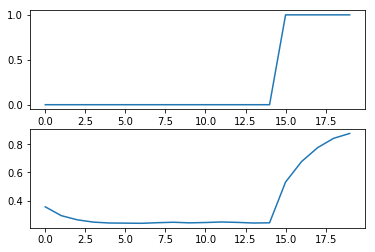

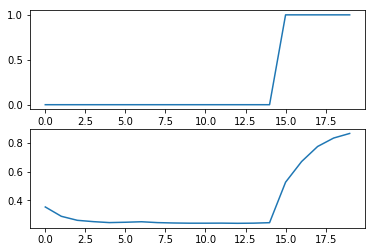

done


In [6]:
dqn_results = evaluate_dqn_policy(dqn_model_path=args.dqn_model_path)

Num to choose: 2, informative: True
Avg/std reward: -21.214455708674627 +/- 14.21237385808166
Action freq (pre action): [0.40962476 0.39769921 0.39270317 0.40024095 0.3997319  0.
 0.         0.         0.         0.        ]
Action freq (joint): 0.2
Average gain for class 1 among dead patient: 0.37620420681228356


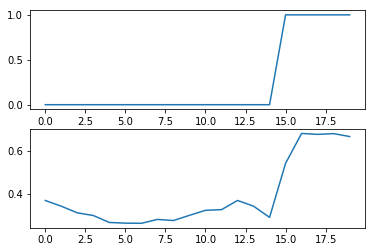

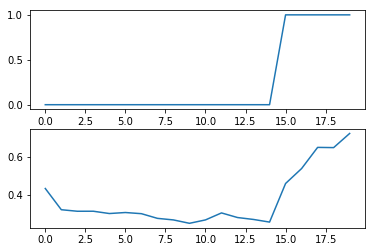

done


In [7]:
random_results = evaluate_random_policy(2)

In [8]:
dqn_results.keys()

dict_keys(['t_len', 'rewards', 'actions', 'gain', 'gain_class1', 'cur_prob', 'response_progression', 'dead', 'gamma'])

In [9]:
dead_patient_idx = [i for i,d in enumerate(dqn_results['dead']) if d]

In [10]:
i = dead_patient_idx[0]
rp = dqn_results['response_progression'][i]
t = np.arange(len(rp))
a = dqn_results['actions'][i, :len(rp)]
m = patient_database.all_measurements[i]
g_c1 = np.sum(dqn_results['gain_class1'][i], axis=1)[:len(rp)]
prob = dqn_results['cur_prob'][i, :len(rp)]

In [11]:
from utils.plotting import plot_line_simple, plot_scatter_simple, plot_hist_simple

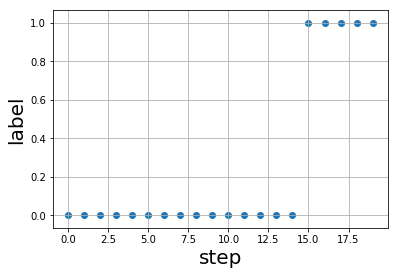

In [12]:
plot_scatter_simple(t, rp, xlabel='step', ylabel='label')

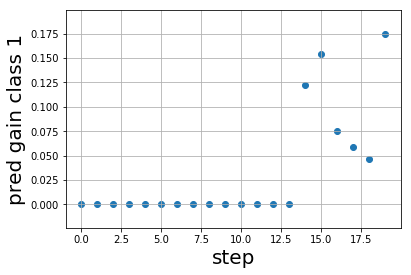

In [13]:
plot_scatter_simple(t, g_c1, xlabel='step', ylabel='pred gain class 1')

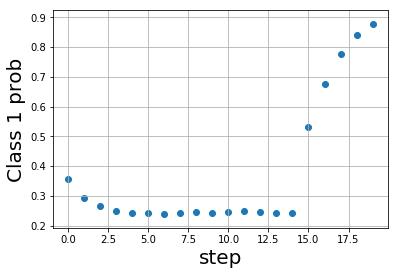

In [14]:
plot_scatter_simple(t, prob, xlabel='step', ylabel='Class 1 prob')

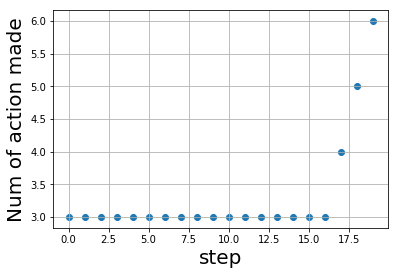

In [15]:
plot_scatter_simple(t, np.sum(a, 1), xlabel='step', ylabel='Num of action made')

In [16]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [17]:
def plot_measurement(m, a, names=None):
    f, ax = plt.subplots(m.shape[1], figsize=(15, 9), sharey=True, sharex=True, tight_layout=True)
    for i in range(m.shape[1]):
        x = [j for j, v in enumerate(a[:, i]) if v and j < m.shape[0] -5]
        y = [m[j, i] for j in x]
        if len(y):
            ax[i].scatter(x, y, alpha=1, c='b')
        x = [j for j, v in enumerate(a[:, i]) if v==0 and j < m.shape[0] -5]
        y = [m[j, i] for j in x]
        if len(y):
            ax[i].scatter(x, y, alpha=0.2, c='b')
            
        x = [j for j, v in enumerate(a[:, i]) if v and j >= m.shape[0] -5]
        y = [m[j, i] for j in x]
        if len(y):
            ax[i].scatter(x, y, alpha=1, c='r')
        x = [j for j, v in enumerate(a[:, i]) if v==0 and j >= m.shape[0] - 5]
        y = [m[j, i] for j in x]
        if len(y):
            ax[i].scatter(x, y, alpha=0.2, c='r')
        if names is not None:
            ax[i].set_xlabel(names[i])
    plt.show()

/Users/MJ/miniconda3/envs/ml/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


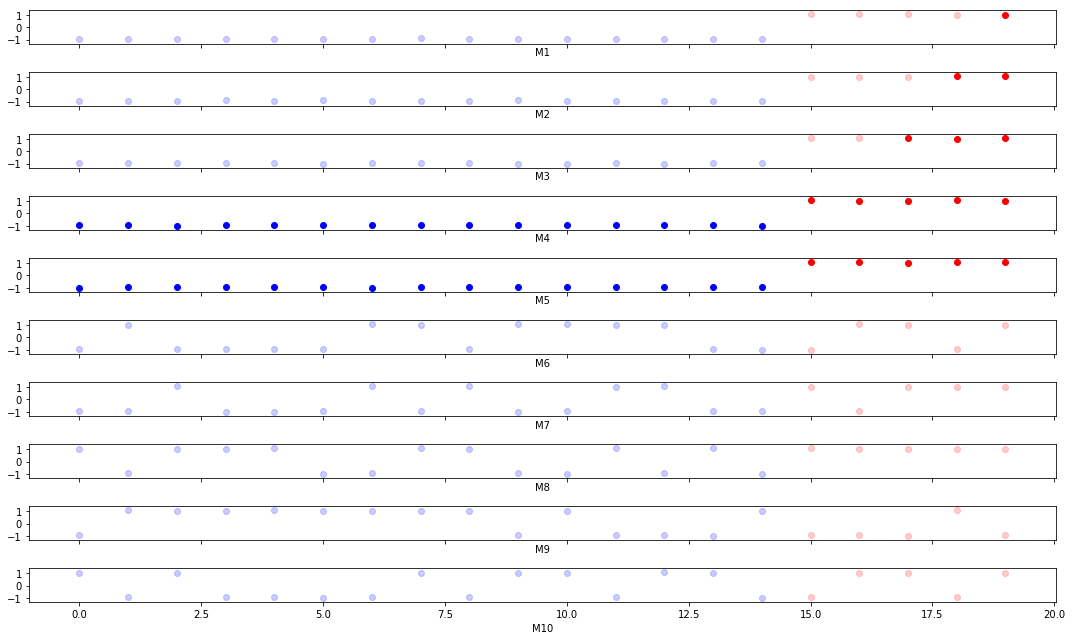

<Figure size 432x288 with 0 Axes>

In [19]:
plot_measurement(m, a, names=['M' + str(i) for i in range(1, 11)])
plt.savefig('/Users/MJ/Desktop/temp.pdf')